In [8]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline
sns.set(color_codes=True)

In [9]:
# Install the Kaggle library
!pip install kaggle


# Move the uploaded file to the appropriate location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d birdy654/deep-voice-deepfake-voice-recognition

Dataset URL: https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition
License(s): other
deep-voice-deepfake-voice-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
from zipfile import ZipFile
dataset='/content/deep-voice-deepfake-voice-recognition.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print("The dataset is extracted")

The dataset is extracted


In [12]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.5 MB/s eta 0:00:00


In [13]:
import pandas as pd
import numpy as np
import librosa
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    LSTM,
    Bidirectional,
    Dropout,
    BatchNormalization,
    Dense,
    MaxPooling1D,
    concatenate,
    GlobalAveragePooling1D,
    Flatten,
)

from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from keras.models import save_model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [14]:
data_path = "/content/KAGGLE/DATASET-balanced.csv"
audio_data = pd.read_csv(data_path)

In [15]:
label_encoder = LabelEncoder()
audio_data['LABEL'] = label_encoder.fit_transform(audio_data['LABEL'])

audio_data.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.338055,0.027948,2842.948867,4322.916759,6570.586186,0.041050,-462.169586,90.311272,19.073769,24.046888,...,-6.686564,0.902086,-7.251551,-1.198342,4.747403,-4.986279,0.953935,-5.013138,-6.779060,0
1,0.443766,0.037838,2336.129597,3445.777044,3764.949874,0.047730,-409.413422,120.348808,-7.161531,5.114784,...,-2.131157,-6.876417,-1.359395,0.326401,-5.420016,-2.109968,-1.757634,-9.537907,-8.494421,0
2,0.302528,0.056578,2692.988386,2861.133180,4716.610271,0.080342,-318.996033,120.490273,-24.625771,23.891073,...,-5.853725,-3.724773,-6.627182,-5.117002,-6.072106,-0.994653,-1.617120,-3.922354,-7.033001,0
3,0.319933,0.031504,2241.665382,3503.766175,3798.641521,0.047180,-404.636749,136.320908,2.308172,-3.907071,...,-1.898315,-2.046493,-7.176277,-3.293508,4.209121,0.121835,-5.407063,-3.654926,-3.274857,0
4,0.420055,0.016158,2526.069123,3102.659519,5025.077899,0.051905,-410.497925,152.731400,-18.266771,51.993462,...,-1.952340,0.810868,6.238493,6.555839,7.535542,2.849219,2.616843,-1.793357,-5.060998,0


In [16]:
y = audio_data['LABEL']
X = audio_data.drop('LABEL', axis = 1)

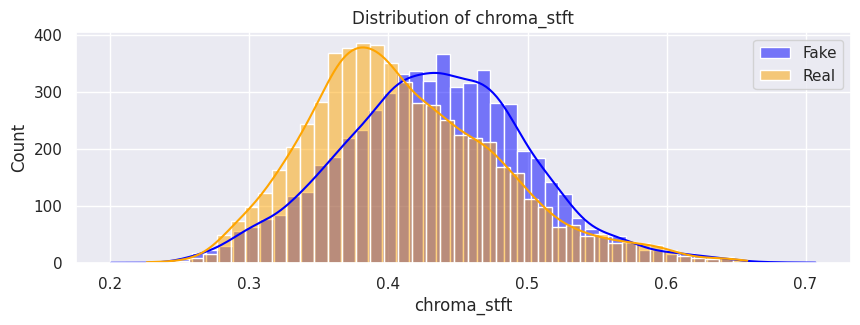

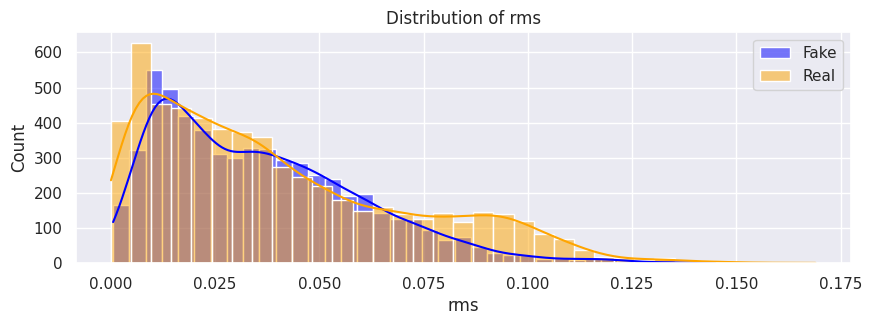

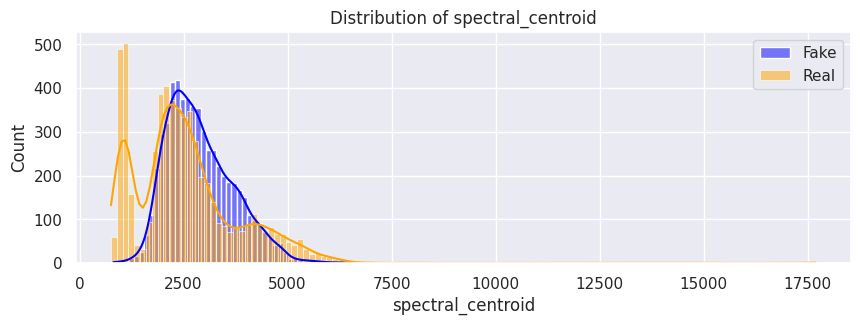

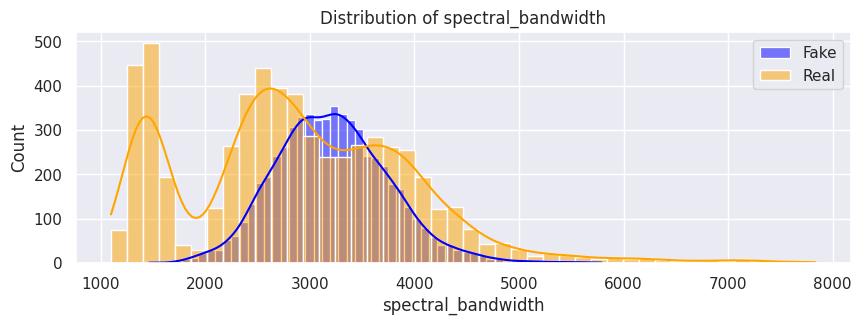

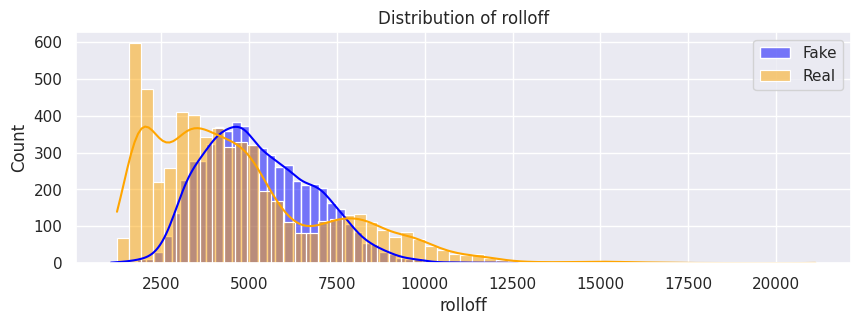

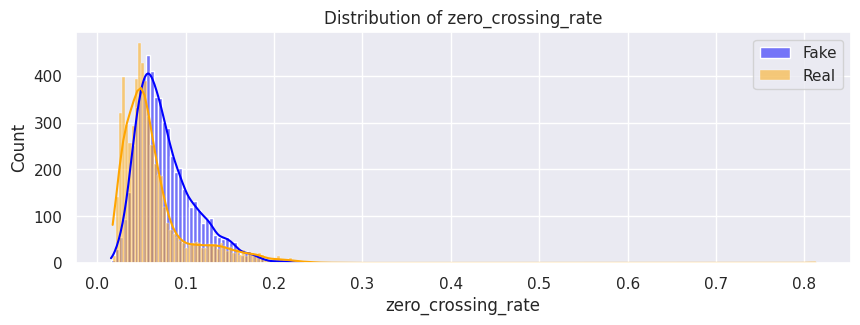

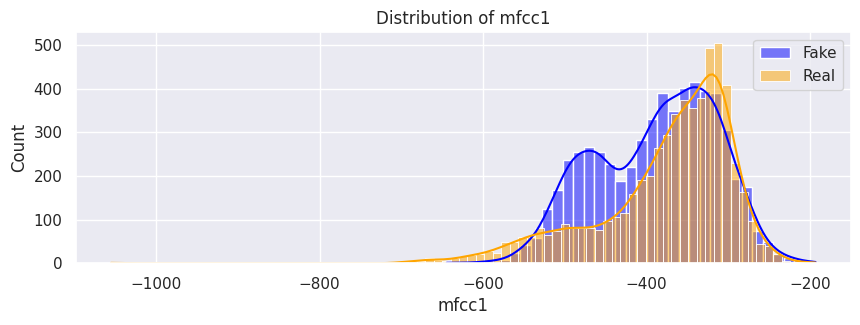

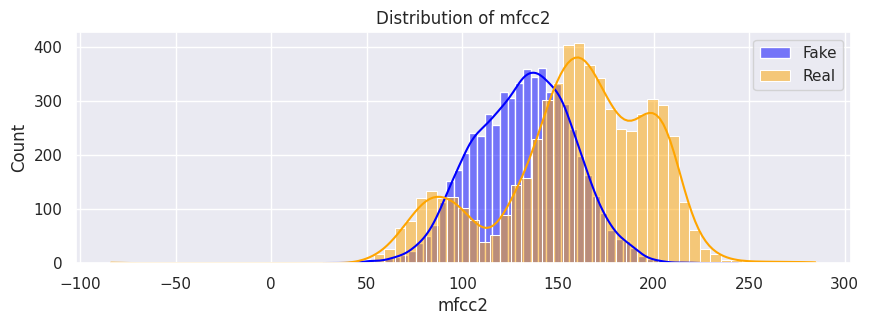

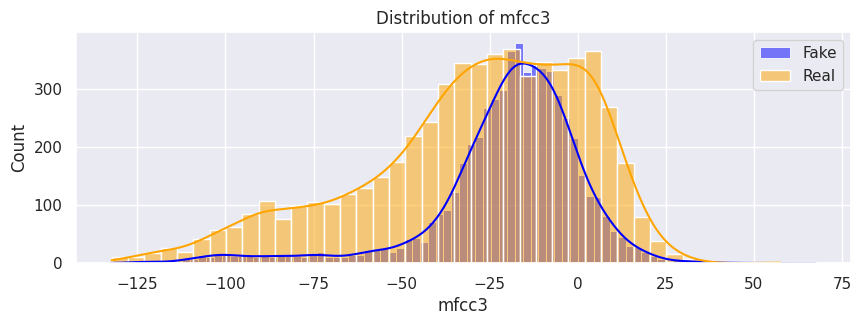

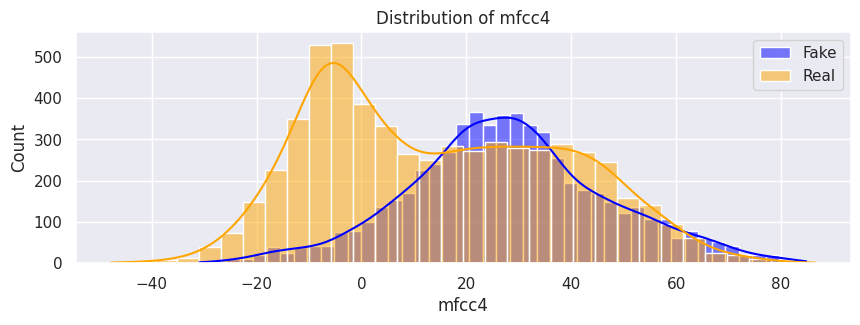

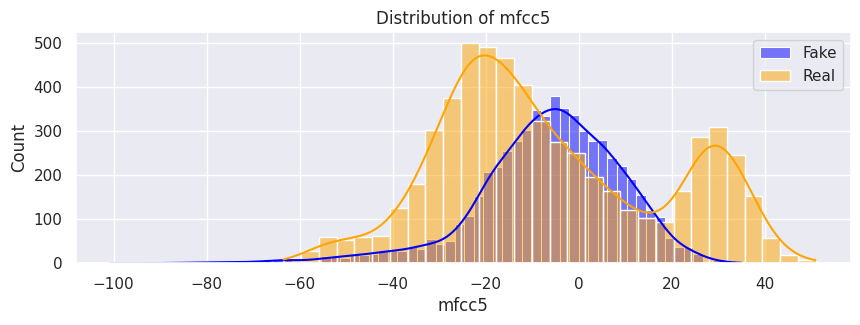

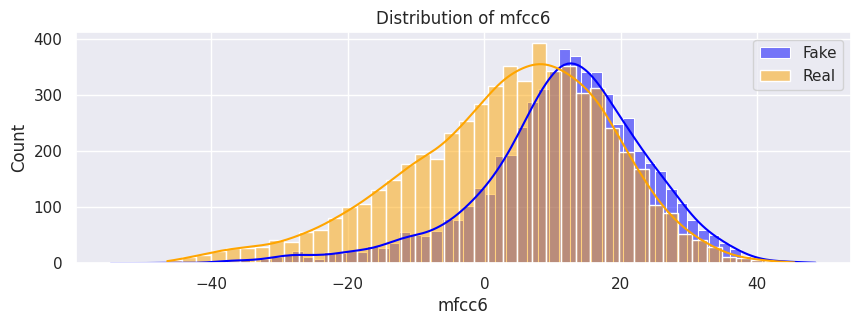

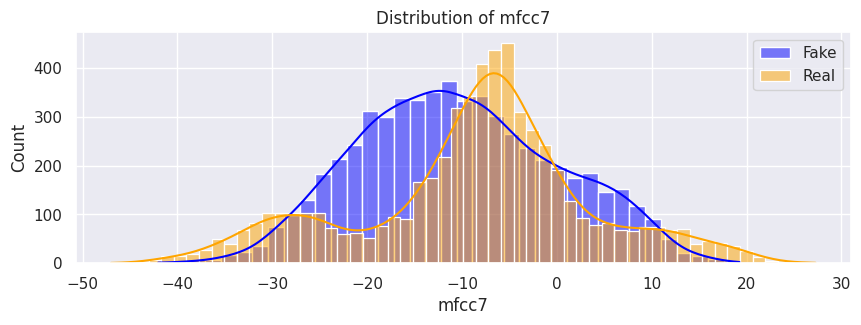

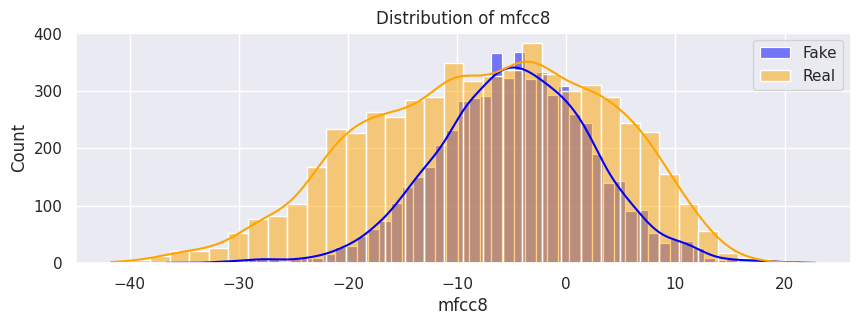

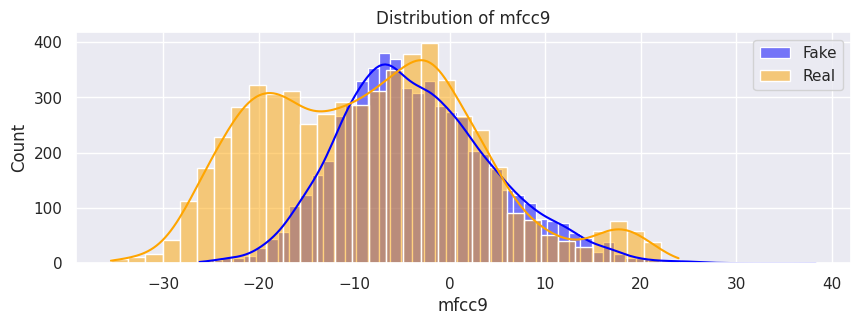

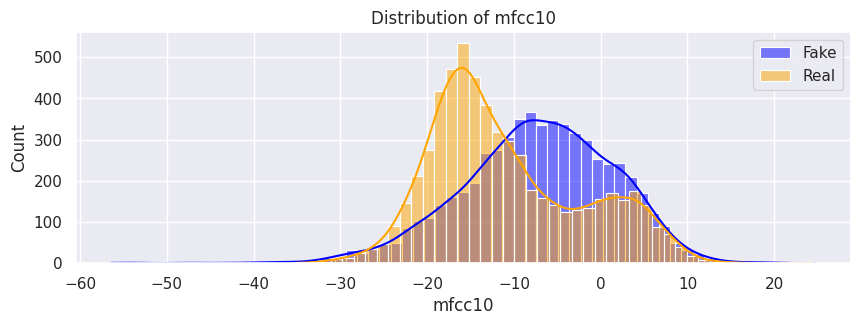

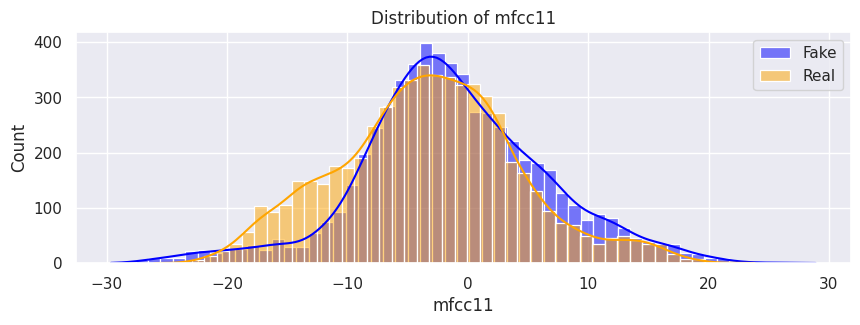

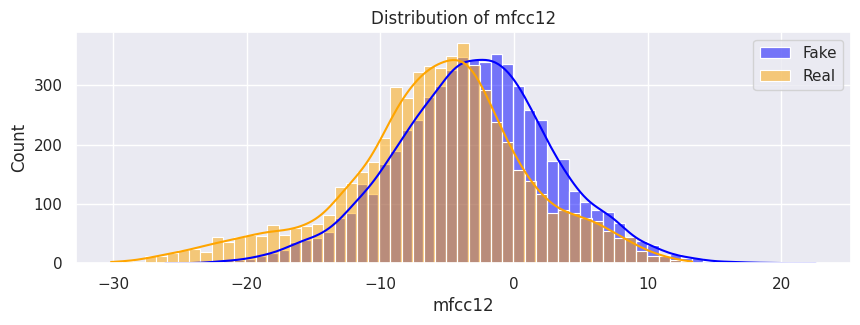

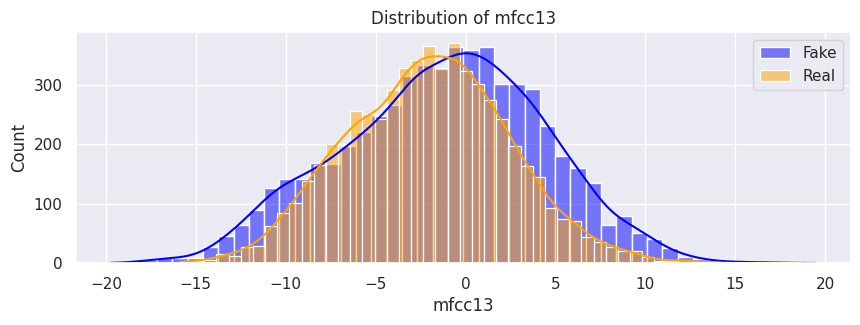

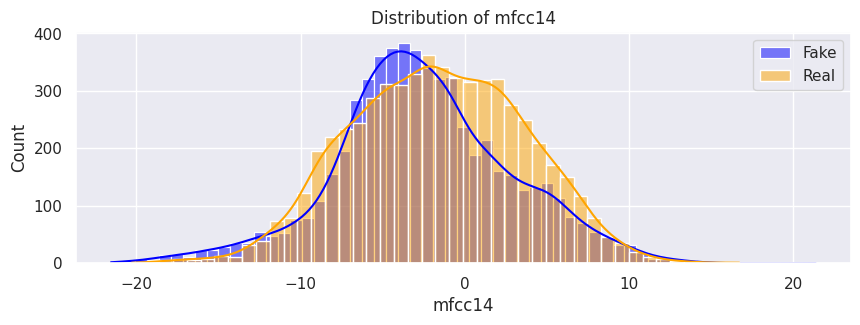

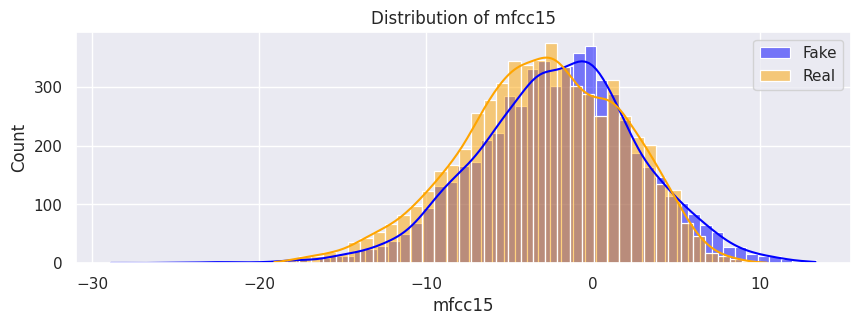

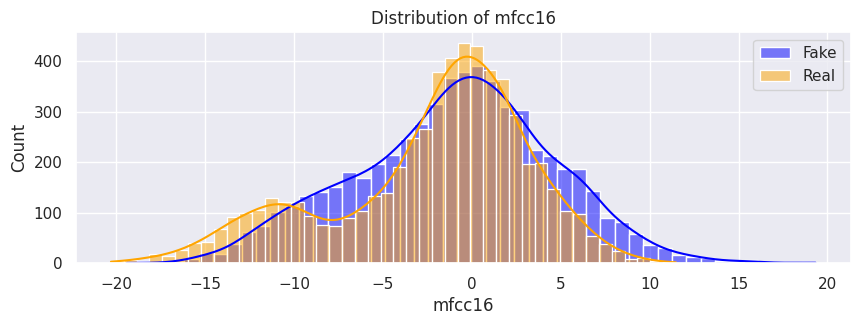

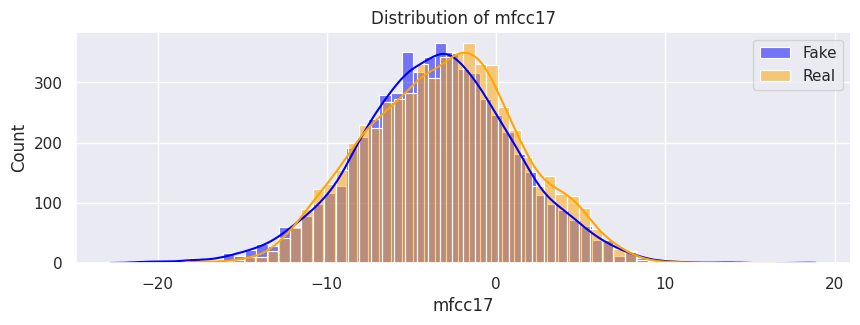

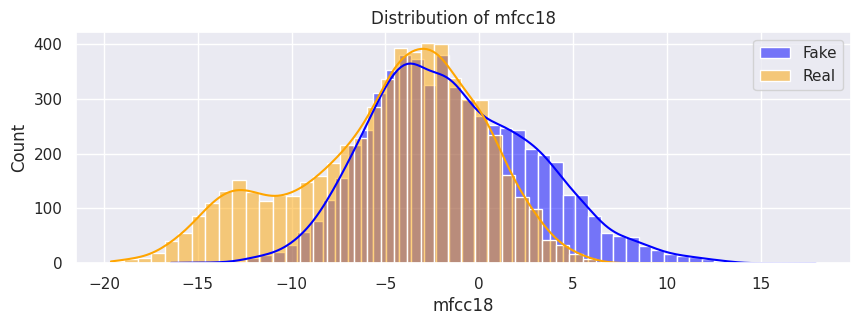

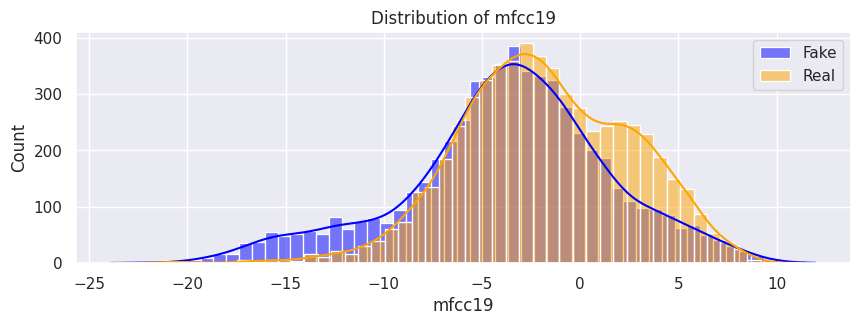

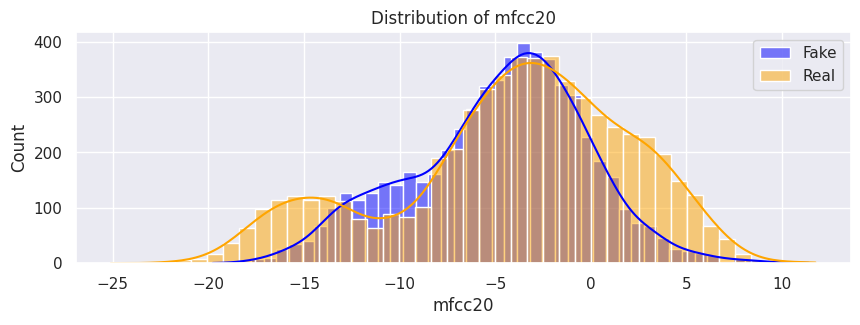

In [17]:
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
for column in X:
    plt.figure(figsize=(10, 3))
    sns.histplot(audio_data[audio_data['LABEL'] == 0][column], kde=True, label='Fake', color='blue')
    sns.histplot(audio_data[audio_data['LABEL'] == 1][column], kde=True, label='Real', color='orange')
    plt.title(f'Distribution of {column}')
    plt.legend()
    plt.show()

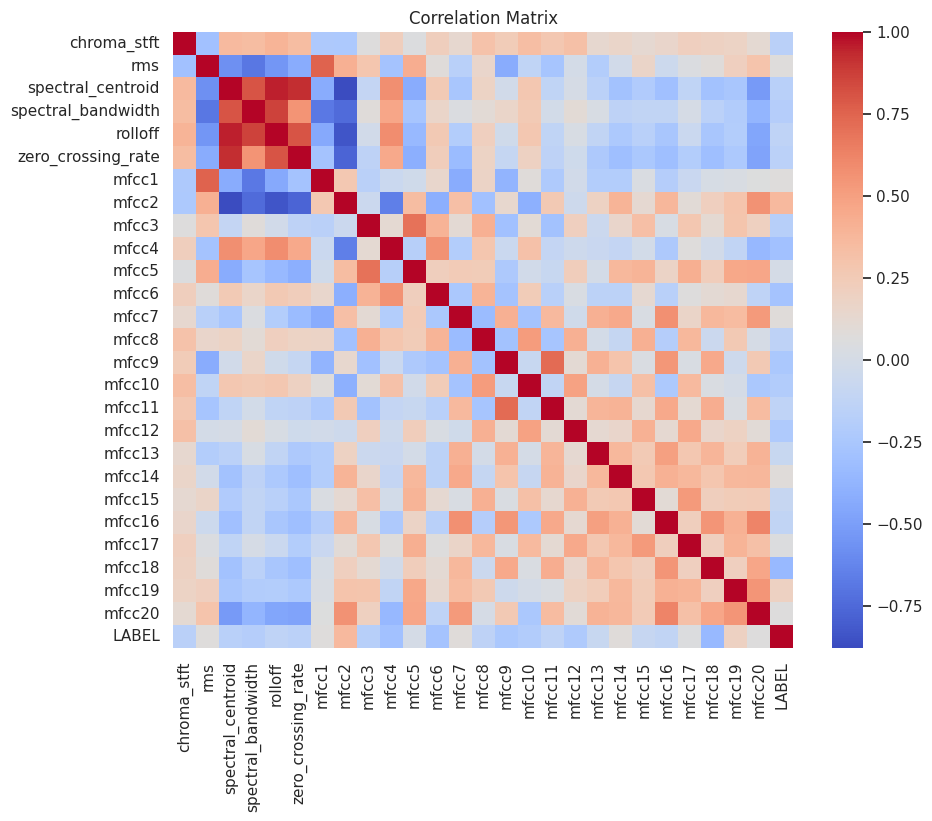

In [18]:
import seaborn as sns

correlation_matrix = audio_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

LSTM

In [19]:
X = X.values
y = y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True ,random_state=42)

In [20]:
X_reshaped = np.zeros((X_train.shape[0], 17, 10))

for i in range(17):
    X_reshaped[:, i, :] = X_train[:, i:i + 10]

y_reshaped = np.reshape(y_train, (y_train.shape[0], 1))

X_train = X_reshaped
y_train = y_reshaped

In [21]:
X_test_reshaped = np.zeros((X_test.shape[0], 17, 10))

for i in range(17):
    X_test_reshaped[:, i, :] = X_test[:, i:i + 10]

y_test_reshaped = np.reshape(y_test, (y_test.shape[0], 1))

X_test = X_test_reshaped
y_test = y_test_reshaped

In [22]:
print(X_train.shape)
print(y_train.shape)

(9422, 17, 10)
(9422, 1)


In [23]:
model = Sequential()

model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(64))

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(32 , activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation = 'sigmoid'))

optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss = BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 17, 64)            19200     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [24]:
history = model.fit(X_train, y_train, batch_size=32, epochs=20)

plt.plot(history.history['accuracy'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss'])
plt.show()

Epoch 1/20
295/295 [==============================] - 19s 34ms/step - loss: 0.6127 - accuracy: 0.6758
Epoch 2/20
295/295 [==============================] - 9s 31ms/step - loss: 0.3053 - accuracy: 0.8864
Epoch 3/20
295/295 [==============================] - 6s 19ms/step - loss: 0.1826 - accuracy: 0.9410
Epoch 4/20
295/295 [==============================] - 7s 23ms/step - loss: 0.1338 - accuracy: 0.9569
Epoch 5/20
295/295 [==============================] - 6s 19ms/step - loss: 0.1149 - accuracy: 0.9635
Epoch 6/20
295/295 [==============================] - 7s 24ms/step - loss: 0.0967 - accuracy: 0.9687
Epoch 7/20
295/295 [==============================] - 5s 18ms/step - loss: 0.0796 - accuracy: 0.9750
Epoch 8/20
295/295 [==============================] - 7s 23ms/step - loss: 0.0683 - accuracy: 0.9790
Epoch 9/20
295/295 [==============================] - 6s 19ms/step - loss: 0.0577 - accuracy: 0.9830
Epoch 10/20
295/295 [==============================] - 6s 22ms/step - loss: 0.0562 - accur

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy'])
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming `model` is your trained Sequential model

# Predict probabilities for each class
y_pred_prob = model.predict(X_test_reshaped)

# Convert probabilities to predicted class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Generating and printing classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generating and printing confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Wirenet

In [25]:
X_train,X_Test,Y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
X_train.shape[1]

26

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_Test)
X_train_std = X_train_std.reshape((X_train_std.shape[0], X_train_std.shape[1], 1))
X_test_std = X_test_std.reshape((X_test_std.shape[0], X_test_std.shape[1], 1))

In [ ]:
def WIRENetSpoofImprovedEnhanced(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 3, activation="relu", padding="same")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(256, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.5)(x)  # Increased dropout rate for regularization
    x = Conv1D(512, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.5)(x)
    x = Conv1D(64, 3, activation="relu", padding="same")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(256, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.5)(x)
    x = Conv1D(512, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model
input_shape = (X_train_std.shape[1], 1)
def lr_schedule(epoch, lr):
    if epoch > 0 and epoch % 10 == 0:
        return lr * 0.1
    return lr
model = WIRENetSpoofImprovedEnhanced(input_shape)
model.compile(
    optimizer=Adam(learning_rate=0.000001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    X_train_std,
    Y_train,
    epochs=20,
    batch_size=32)

In [ ]:
test_loss, test_acc = model.evaluate(X_test_std, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
# Import necessary libraries
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have trained and evaluated your model as shown earlier...

# Generate predictions
y_pred = model.predict(X_test_std)
y_pred_binary = (y_pred > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred_binary))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='wirenet_architecture.png', show_shapes=True, show_layer_names=True)

LCBNet

Epoch 1/50
118/118 [==============================] - 3s 6ms/step - loss: 0.3563 - accuracy: 0.8438 - val_loss: 0.2077 - val_accuracy: 0.9401
Epoch 2/50
118/118 [==============================] - 1s 6ms/step - loss: 0.1425 - accuracy: 0.9453 - val_loss: 0.0820 - val_accuracy: 0.9740
Epoch 3/50
118/118 [==============================] - 1s 7ms/step - loss: 0.0979 - accuracy: 0.9639 - val_loss: 0.0536 - val_accuracy: 0.9814
Epoch 4/50
118/118 [==============================] - 1s 7ms/step - loss: 0.0737 - accuracy: 0.9727 - val_loss: 0.0489 - val_accuracy: 0.9836
Epoch 5/50
118/118 [==============================] - 1s 7ms/step - loss: 0.0697 - accuracy: 0.9759 - val_loss: 0.0337 - val_accuracy: 0.9910
Epoch 6/50
118/118 [==============================] - 1s 6ms/step - loss: 0.0573 - accuracy: 0.9810 - val_loss: 0.0303 - val_accuracy: 0.9920
Epoch 7/50
118/118 [==============================] - 1s 5ms/step - loss: 0.0484 - accuracy: 0.9829 - val_loss: 0.0349 - val_accuracy: 0.9894
Epoch 

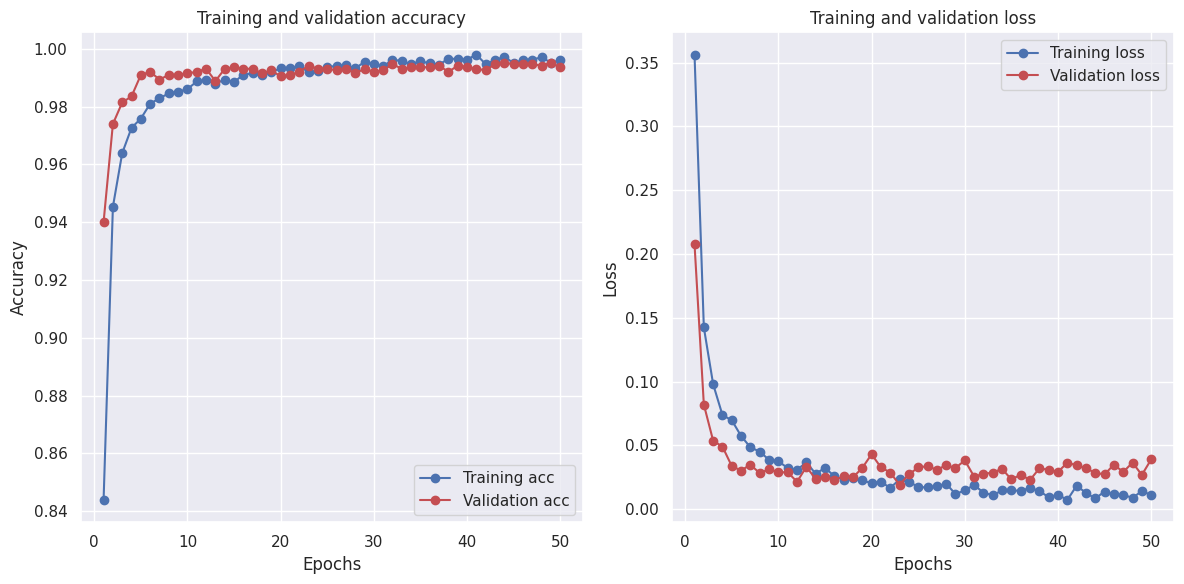

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Assuming X_train, X_Test, Y_train, y_test are already defined
# Ensure X and y are loaded and processed appropriately before this step

# Splitting the data into training and testing sets with stratification and a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardizing the features using StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Reshape the data for compatibility with the model (assuming X_train_std and X_test_std are 2D arrays)
X_train_std = X_train_std.reshape((X_train_std.shape[0], X_train_std.shape[1], 1))
X_test_std = X_test_std.reshape((X_test_std.shape[0], X_test_std.shape[1], 1))

# Define the model architecture
input_audio = Input(shape=(X_train_std.shape[1],))
input_visual = Input(shape=(X_train_std.shape[1],))

# Audio branch
audio_branch = Dense(128, activation='relu')(input_audio)
audio_branch = BatchNormalization()(audio_branch)
audio_branch = Dropout(0.5)(audio_branch)
audio_branch = Dense(64, activation='relu')(audio_branch)

# Visual branch
visual_branch = Dense(128, activation='relu')(input_visual)
visual_branch = BatchNormalization()(visual_branch)
visual_branch = Dropout(0.5)(visual_branch)
visual_branch = Dense(64, activation='relu')(visual_branch)

# Concatenate both branches
merged = concatenate([audio_branch, visual_branch])
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.5)(merged)
output = Dense(1, activation='sigmoid')(merged)

# Define the model
model = Model(inputs=[input_audio, input_visual], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([X_train_std, X_train_std], y_train, epochs=50, batch_size=64, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate([X_test_std, X_test_std], y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

# Generate predictions
y_pred = model.predict([X_test_std, X_test_std])
y_pred_classes = (y_pred > 0.5).astype(int)

# Classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

# Plot training & validation accuracy and loss
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


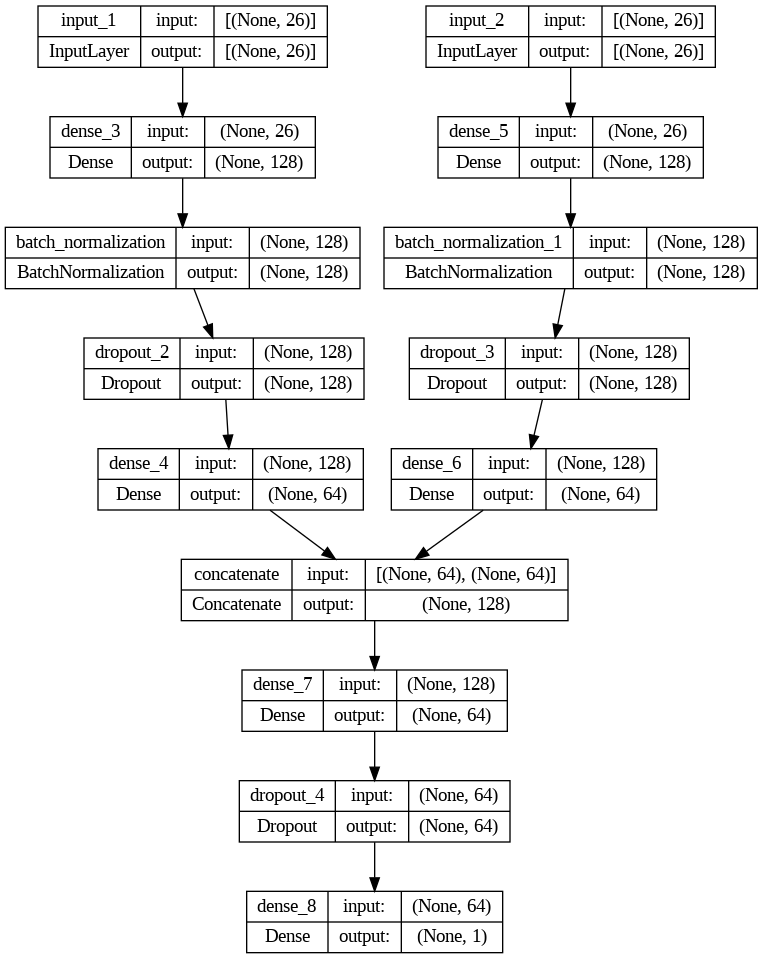

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.9872665534804754


Accuracy: 0.9872665534804754
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1193
           1       0.99      0.99      0.99      1163

    accuracy                           0.99      2356
   macro avg       0.99      0.99      0.99      2356
weighted avg       0.99      0.99      0.99      2356



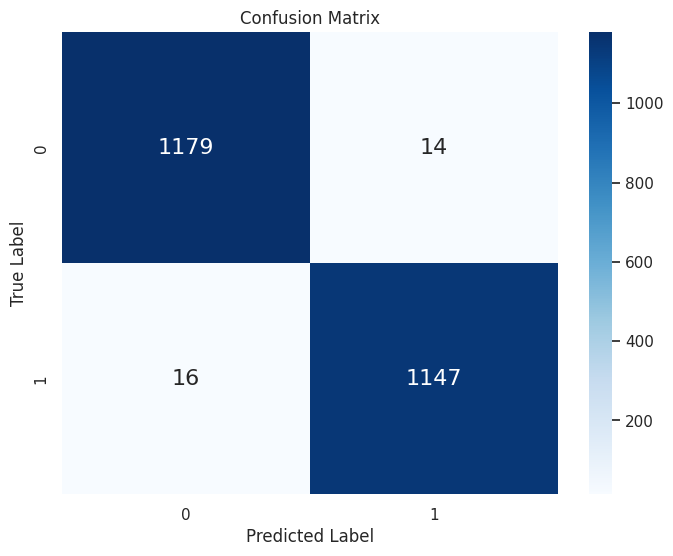

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X and y are your data and labels

# Step 1: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Model Training
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 3: Predictions and Evaluation
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Step 4: Generate Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 5: Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 16})

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Support Vector Machine

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [ ]:
y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.9125636672325976


Accuracy: 0.9129881154499151
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1193
           1       0.92      0.91      0.91      1163

    accuracy                           0.91      2356
   macro avg       0.91      0.91      0.91      2356
weighted avg       0.91      0.91      0.91      2356



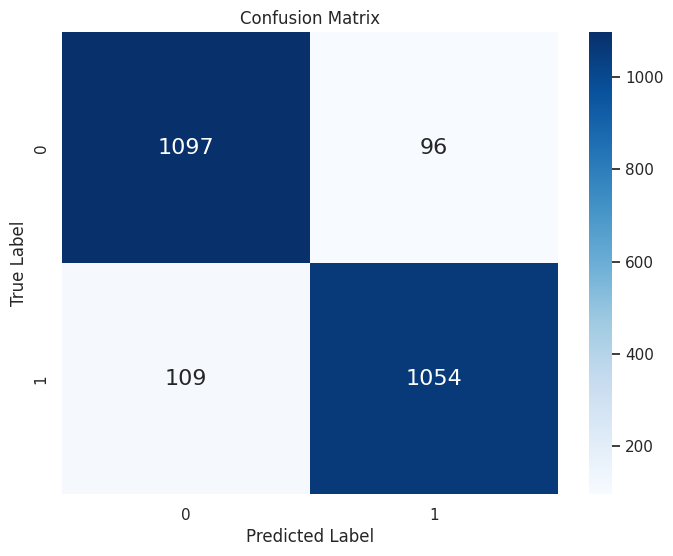

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_train, X_test, y_train, y_test are your data and labels

# Step 1: Scale Data and Train/Test Split
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 2: Model Training and Prediction
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Step 3: Generate Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 4: Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 16})

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.7491511035653651


Accuracy: 0.7491511035653651
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1193
           1       0.74      0.76      0.75      1163

    accuracy                           0.75      2356
   macro avg       0.75      0.75      0.75      2356
weighted avg       0.75      0.75      0.75      2356



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


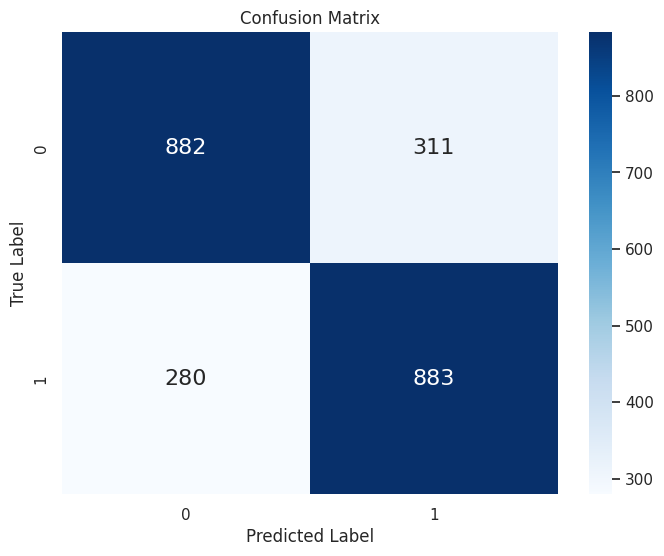

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X and y are your data and labels

# Step 1: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Model Training
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Step 3: Predictions and Evaluation
y_pred = logreg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Step 4: Generate Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 5: Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 16})

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


K-Nearest Neighbors (KNN)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.8064516129032258


Accuracy: 0.8064516129032258
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1193
           1       0.81      0.80      0.80      1163

    accuracy                           0.81      2356
   macro avg       0.81      0.81      0.81      2356
weighted avg       0.81      0.81      0.81      2356



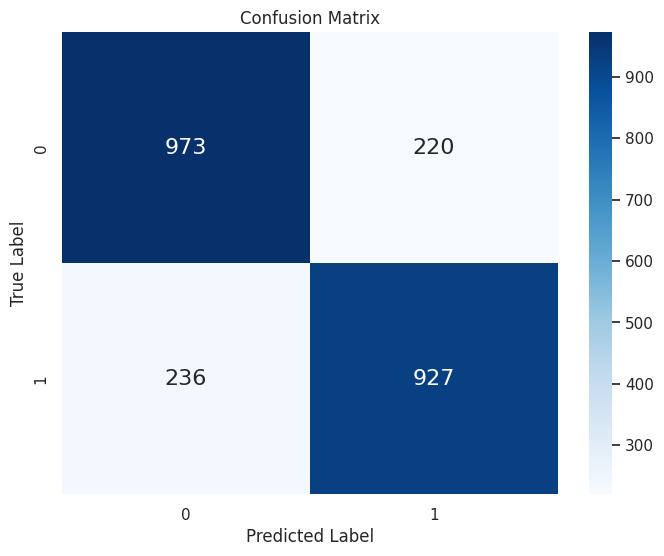

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X and y are your data and labels

# Step 1: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Model Training
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Step 3: Predictions and Evaluation
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Step 4: Generate Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 5: Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 16})

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Gradient Boost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
y_pred = gb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.9711375212224108


Accuracy: 0.9711375212224108
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1193
           1       0.98      0.96      0.97      1163

    accuracy                           0.97      2356
   macro avg       0.97      0.97      0.97      2356
weighted avg       0.97      0.97      0.97      2356



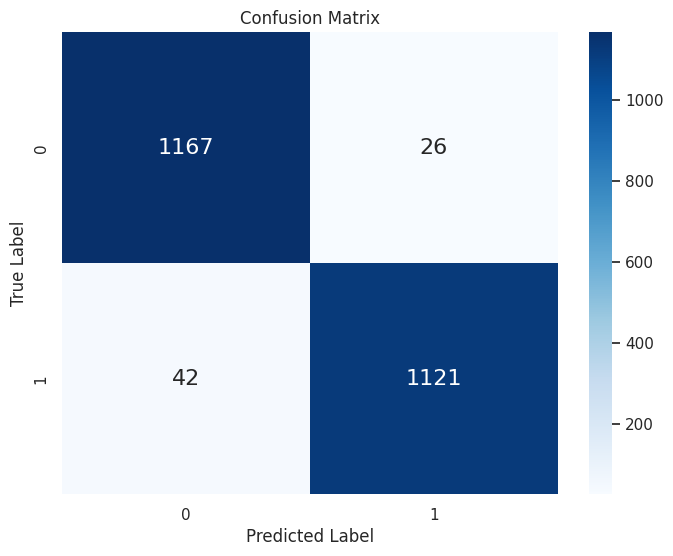

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X and y are your data and labels

# Step 1: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Model Training
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)

# Step 3: Predictions and Evaluation
y_pred = gb.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Step 4: Generate Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 5: Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 16})

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


AdaBoost Classifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)
ada_classifier = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, random_state=42)
ada_classifier.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=42),
                   random_state=42)

In [ ]:
y_pred = ada_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.9223259762308998


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.9223259762308998
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1193
           1       0.94      0.91      0.92      1163

    accuracy                           0.92      2356
   macro avg       0.92      0.92      0.92      2356
weighted avg       0.92      0.92      0.92      2356



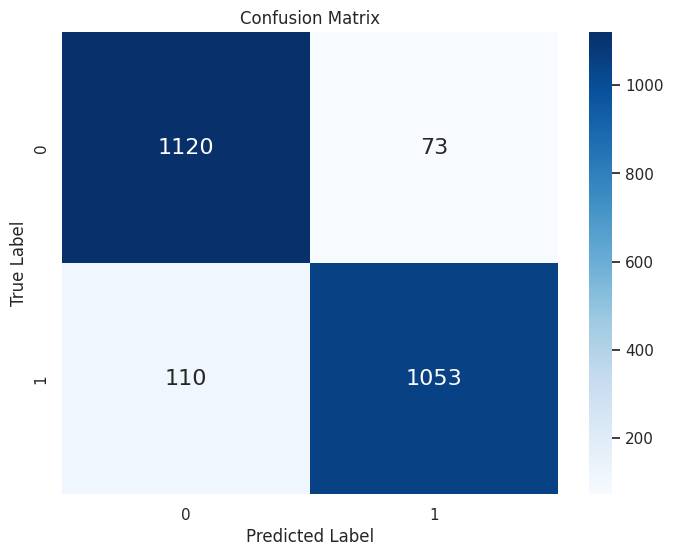

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X and y are your data and labels

# Step 1: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Model Training
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)
ada_classifier = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=42)
ada_classifier.fit(X_train, y_train)

# Step 3: Predictions and Evaluation
y_pred = ada_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Step 4: Generate Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 5: Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 16})

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


XGBoost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
xgb_classifier = XGBClassifier(n_estimators=100)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.9932088285229203


Accuracy: 0.9932088285229203
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1193
           1       0.99      1.00      0.99      1163

    accuracy                           0.99      2356
   macro avg       0.99      0.99      0.99      2356
weighted avg       0.99      0.99      0.99      2356



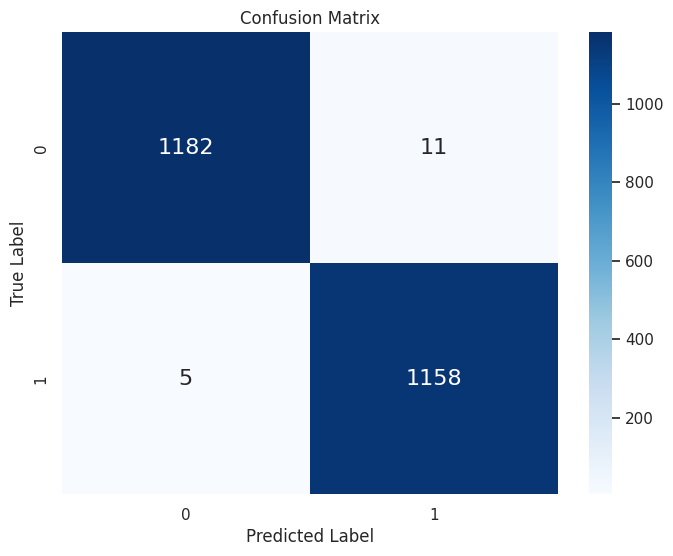

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X and y are your data and labels

# Step 1: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Model Training
xgb_classifier = XGBClassifier(n_estimators=100)
xgb_classifier.fit(X_train, y_train)

# Step 3: Predictions and Evaluation
y_pred = xgb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Step 4: Generate Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 5: Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 16})

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


CatBoost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
catboost_classifier = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_seed=42, verbose=0)
catboost_classifier.fit(X_train, y_train)

In [ ]:
y_pred = catboost_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.9876910016977929


Accuracy: 0.9876910016977929
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1193
           1       0.99      0.99      0.99      1163

    accuracy                           0.99      2356
   macro avg       0.99      0.99      0.99      2356
weighted avg       0.99      0.99      0.99      2356



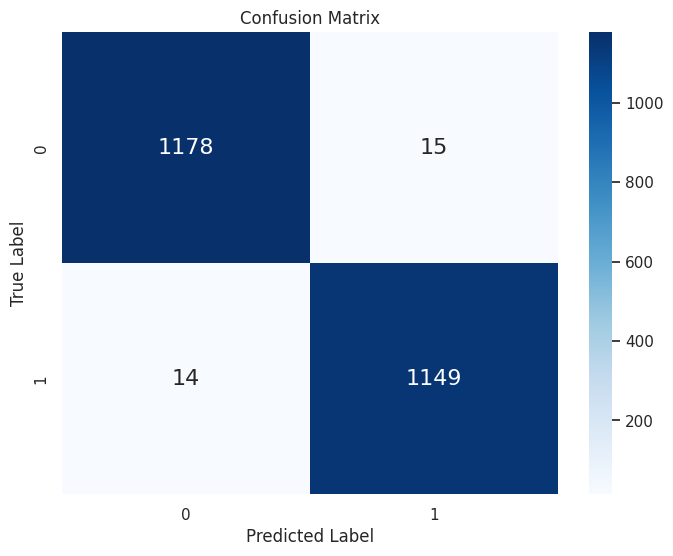

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X and y are your data and labels

# Step 1: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Model Training
catboost_classifier = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_seed=42, verbose=0)
catboost_classifier.fit(X_train, y_train)

# Step 3: Predictions and Evaluation
y_pred = catboost_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Step 4: Generate Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 5: Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 16})

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


GBM

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
gbm_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

In [ ]:
gbm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = gbm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9881154499151104


Accuracy: 0.9881154499151104
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1193
           1       0.99      0.99      0.99      1163

    accuracy                           0.99      2356
   macro avg       0.99      0.99      0.99      2356
weighted avg       0.99      0.99      0.99      2356



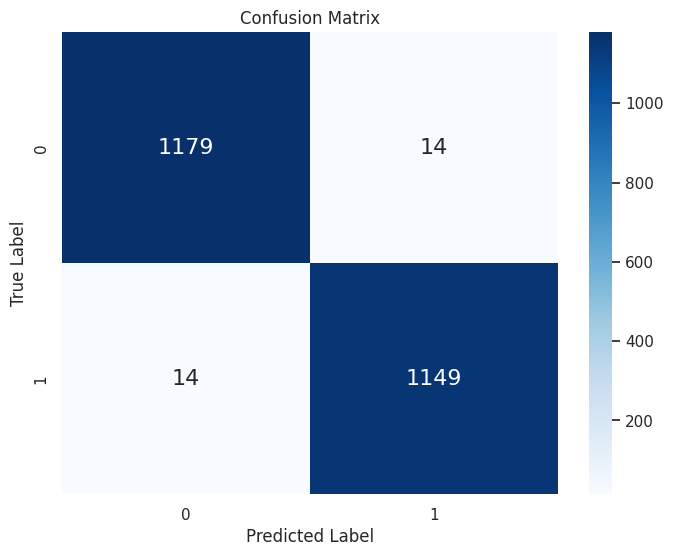

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X and y are your data and labels

# Step 1: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Model Training
gbm_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
gbm_classifier.fit(X_train, y_train)

# Step 3: Predictions and Evaluation
y_pred = gbm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Step 4: Generate Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 5: Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 16})

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


CNN

VGG16

In [ ]:
# Verify the shape of X_train and X_test
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (9422, 26)
X_test shape: (2356, 26)


In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Epoch 1/50
59/59 [==============================] - 5s 39ms/step - loss: 87.6537 - accuracy: 0.4912 - val_loss: 2.9274 - val_accuracy: 0.6292
Epoch 2/50
59/59 [==============================] - 2s 25ms/step - loss: 23.7889 - accuracy: 0.5111 - val_loss: 1.7309 - val_accuracy: 0.5332
Epoch 3/50
59/59 [==============================] - 2s 31ms/step - loss: 14.6360 - accuracy: 0.5094 - val_loss: 1.1455 - val_accuracy: 0.5183
Epoch 4/50
59/59 [==============================] - 1s 25ms/step - loss: 8.9199 - accuracy: 0.4987 - val_loss: 1.1550 - val_accuracy: 0.5003
Epoch 5/50
59/59 [==============================] - 1s 17ms/step - loss: 3.9195 - accuracy: 0.5051 - val_loss: 1.0813 - val_accuracy: 0.5013
Epoch 6/50
59/59 [==============================] - 1s 14ms/step - loss: 1.6937 - accuracy: 0.5019 - val_loss: 1.0806 - val_accuracy: 0.5013
Epoch 7/50
59/59 [==============================] - 1s 25ms/step - loss: 1.3617 - accuracy: 0.5017 - val_loss: 1.0799 - val_accuracy: 0.5013
Epoch 8/50

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


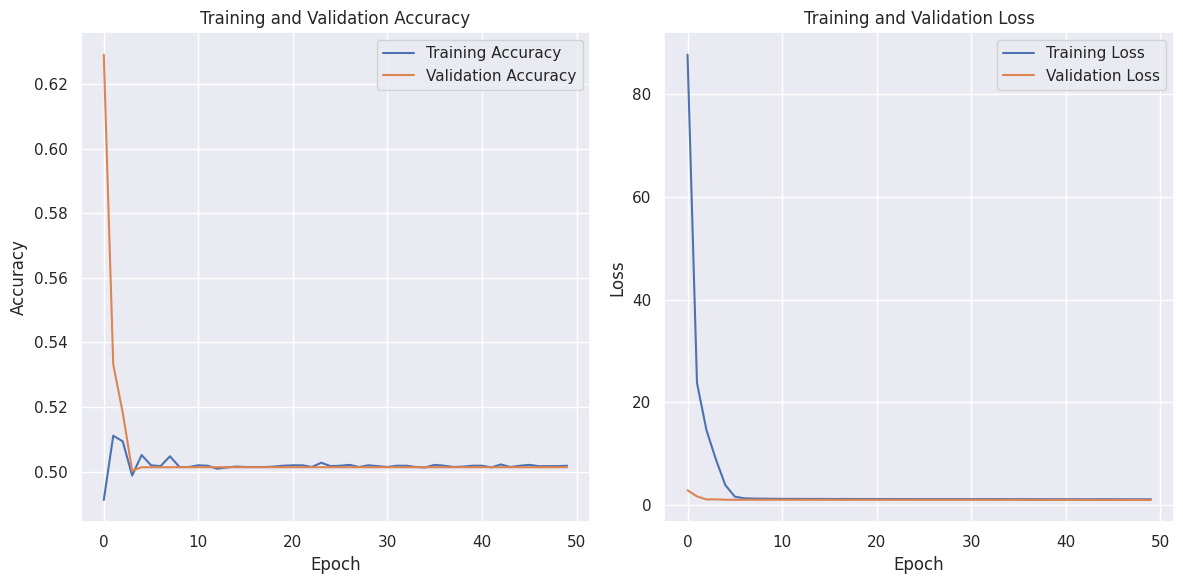

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Assuming X_train, X_test, y_train, y_test are defined

# Define the model
model = Sequential()

# Input and hidden layers
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],),
                kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.4))

model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model with class weights
class_weights = {0: 1, 1: 1.5}  # Adjust class weights based on your data imbalance
history = model.fit(X_train, y_train, epochs=50, batch_size=128,
                    validation_split=0.2, class_weight=class_weights)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


1D cnn

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 26, 64)            256       
                                                                 
 conv1d_9 (Conv1D)           (None, 26, 64)            12352     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 13, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 13, 128)           24704     
                                                                 
 conv1d_11 (Conv1D)          (None, 13, 128)           49280     
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 6, 128)            0         
 g1D)                                                 

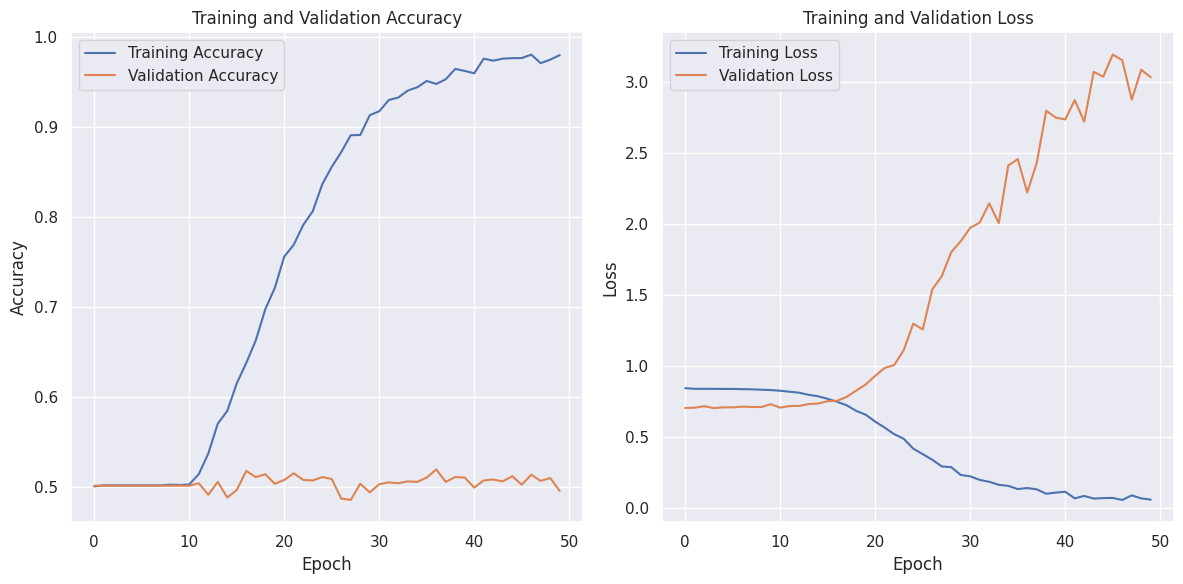

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Assuming X_train_std, X_test_std, y_train, y_test are defined and standardized

# Reshape data for 1D convolution
X_train_std = X_train_std.reshape((X_train_std.shape[0], X_train_std.shape[1], 1))
X_test_std = X_test_std.reshape((X_test_std.shape[0], X_test_std.shape[1], 1))

# Define the model
model = Sequential()

# Input layer
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(X_train_std.shape[1], 1)))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

# Hidden layers
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train_std, y_train, epochs=50, batch_size=128,
                    validation_split=0.2, class_weight={0: 1, 1: 1.5})  # Adjust class weights if needed

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_std, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Generate predictions
y_pred = (model.predict(X_test_std) > 0.5).astype("int32")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming X and y are defined

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for 1D CNN (assuming X is already standardized if needed)
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build 1D CNN model
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model
y_pred_prob = model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


74/74 [==============================] - 0s 2ms/step
Accuracy: 0.9393039049235993

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1193
           1       0.91      0.97      0.94      1163

    accuracy                           0.94      2356
   macro avg       0.94      0.94      0.94      2356
weighted avg       0.94      0.94      0.94      2356


Confusion Matrix:
[[1086  107]
 [  36 1127]]


Resnet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam



# Preprocess data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Load ResNet-50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add custom top layers for CIFAR-10 classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)  # Output layer for 10 classes

# Combine base model and top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in base model (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Generate predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Classification report
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=-1), y_pred))

# Confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()


Transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader

# Load your dataset
data_path = "/content/KAGGLE/DATASET-balanced.csv"
audio_data = pd.read_csv(data_path)

# Encode labels
label_encoder = LabelEncoder()
audio_data['LABEL'] = label_encoder.fit_transform(audio_data['LABEL'])

# Split data into train and test sets
X = audio_data.drop('LABEL', axis=1)
y = audio_data['LABEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize inputs using a pretrained tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize input data
train_encodings = tokenizer(list(X_train.columns), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test.columns), truncation=True, padding=True)

# Convert to PyTorch tensors
train_input_ids = torch.tensor(train_encodings.input_ids)
train_attention_mask = torch.tensor(train_encodings.attention_mask)
train_labels = torch.tensor(y_train.values)

test_input_ids = torch.tensor(test_encodings.input_ids)
test_attention_mask = torch.tensor(test_encodings.attention_mask)
test_labels = torch.tensor(y_test.values)

# Create PyTorch datasets
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)

# Define model and training arguments
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(y)))
training_args = TrainingArguments(
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=10,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()

# Evaluate on the test set
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=-1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generate confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(clr)
